# Figure 4

In [1]:
## Tree figure rendering
import os
from os import path
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

In [2]:
import sys
sys.path.insert(1, '../../code/scripts')

In [3]:
## Basics
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import mdtraj as md
import parseaf as pa
#import tempparse as paf

## Logistic regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['figure.autolayout'] = False

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499'}

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Functions

In [5]:
def get_aa_freq(seq, aa):
    cnt = 0
    for i in seq:
        if i == aa:
            cnt += 1
    aa_freq = cnt / len(seq)
    return aa_freq

In [6]:
def append_percent_aa(row, aa):
    seq = row['region_seq']
    if len(seq) == 0:
        print(row['uni_id'])
    return get_aa_freq(seq, aa)

In [7]:
def get_cnf_freq(cnf_mat):
    cnf_freq = cnf_mat / cnf_mat.sum(axis=1)[:, np.newaxis]
    return cnf_freq

## Data

In [8]:
allregions = pd.read_csv('../../data/af_regions/sc_af_regions_all.csv')

In [9]:
allregions.head(5)

,region_seq,start,end,uni_id,len_region,label
0,VQDLKQLLLNVFNTYKLERSLSELIQKIIEDSSQDLVQQYRKF,1143,1185,P39702,43,helix
1,KEDIEKMVAEAEKFKEEDEKESQRIASKNQLESIAYSLKNTISE,508,551,P10591,44,helix
2,DIIANNAVEEIDRNLNKITKTLNYLRAREWRNMSTVNSTESRLTWL...,138,208,P39704,71,helix
3,KQMFLGSLFGVVLGVTVAKISILFMYVGITSMLLCEWLRY,103,142,P18411,40,helix
4,PASMIFRNLLILEDDLRRQAHEQKILKWQFTLFLASMAGVGAFTFYELY,45,93,P18410,49,helix


In [10]:
cnf_df = pd.read_csv('../../misc/cp_cnf_matrices_posttrim.csv')

In [11]:
cnf_df.head(5)

,FN,TN,TP,FP,n
0,498,8893,6384,689,16464
1,385,2422,980,128,3915
2,41,339,167,4,551
3,2181,7698,4701,1884,16464
4,529,1948,836,602,3915


## 3D: Accuracy of logistic regression model

In [12]:
cnf_matrices = []
sample_size = []
for index, row in cnf_df.iterrows():
    mat = np.array([[row['TN'], row['FP']], [row['FN'], row['TP']]])
    cnf_matrices.append(mat)
    if index < 3:
        sample_size.append(row['n'])

In [13]:
titles = ['Purely helical\nand disordered\nregions',
          'Randomly\ndrawn\nregions',
          'Highly\ncharged\nregions']

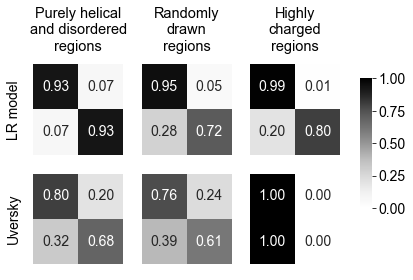

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(5.5, 4), constrained_layout=False)
cbar_ax = fig.add_axes([0.95, .35, .03, .45])

for i, ax in enumerate(axes.flat):
    g = sns.heatmap(pd.DataFrame(get_cnf_freq(cnf_matrices[i])), ax=ax,
                    annot=True, fmt=".2f",
                    xticklabels=['', ''], yticklabels=['', ''],
                    cmap="Greys", cbar= (i == 0),
                    vmin=0, vmax=1,
                    cbar_ax=None if i else cbar_ax)
    g.tick_params(left=False, bottom=False)
    if i < 3:
        g.set_title(titles[i], fontsize=14.5, pad=5)
    #ax.title.set_position([.5, 0.8])
    if i == 0:
        ax.set_ylabel('LR model')
        ax.yaxis.labelpad = 5
    elif i == 3:
        ax.set_ylabel('Uversky')
        ax.yaxis.labelpad = 5
    bottom, top = ax.get_ylim()
    ax.set_aspect('equal', adjustable="datalim")
    #ax.set_ylim(bottom + 0.5, top - 0.5)

#plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.01)
plt.savefig('./plots/Figure3D.png', dpi=300, bbox_inches='tight')

## 3E: Summary of prediction accuracy for 3D

In [15]:
l_acc = []
for i in range(6):
    cnf = cnf_matrices[i]
    accuracy = (cnf[0, 0] + cnf[1, 1]) / np.sum(cnf)
    l_acc.append(accuracy)
sc_acc = np.mean(l_acc[:3])

In [16]:
ticks = ['LR model,\nall regions',
         'LR model,\nrandomly drawn regions',
         'LR model,\nhighly charged regions',
         'Uversky plot,\nall regions',
         'Uversky plot,\nrandomly drawn regions',
         'Uversky plot,\nhighly charged regions']

In [17]:
df_cnf = pd.DataFrame(columns=['model', 'dataset', 'l_acc'])

In [18]:
datasets = ['All regions', 'Random', 'Highly\ncharged']

In [19]:
for i in range(3):
    df_cnf = df_cnf.append({'model': 'LR', 'dataset':datasets[i], 'l_acc': l_acc[i]},
                           ignore_index=True)

In [20]:
for i in range(3):
    df_cnf = df_cnf.append({'model': 'Uversky', 'dataset':datasets[i], 'l_acc': l_acc[i+3]},
                           ignore_index=True)

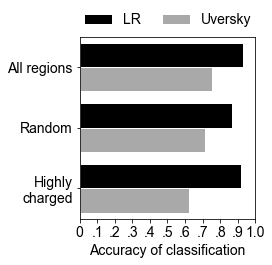

In [25]:
fig, ax = plt.subplots(figsize=(4,4))

sns.barplot(data=df_cnf, y='dataset', x='l_acc', hue='model',
            palette=['black', 'darkgrey'], edgecolor='white')
ax.set_xlabel('Accuracy of classification')
ax.set_ylabel('')
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.05, 0.1))
ax.set_xticklabels(['0', '.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1.0'])
#ax.set_xlabel('Accuracy of classification')
plt.legend(title=None, ncol = 2, frameon=False, columnspacing=1.5,
           bbox_to_anchor=(1.05, 1.2))
plt.tight_layout()
plt.savefig('./plots/Figure3E.png', dpi=300)
plt.show()